In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor


# 1. Przygotuj zbiór uczący i walidacyjny, wykorzystując dołączony do listy kod procedury ekstrakcji cech. Jeśli zamierzasz korzystać z Weki, zalecane jest wykonanie jednorazowego przekształcenia danych i eksportu do jednego ze zgodnych formatów

In [2]:
ratings_data = pd.read_excel('jester-data-1.xls', header=None)
ratings_data = ratings_data.iloc[:, 1:].replace(99, float('nan'))
ratings = ratings_data.mean()


In [3]:
jokes_data = []

for i in range(1, 101):
    file_name = f'jokes/init{i}.html'
    with open(file_name, 'r') as file:
        joke_html = file.read()
        soup = BeautifulSoup(joke_html, 'html.parser')
        joke_text = soup.find('font', size='+1').text.strip()
        jokes_data.append(joke_text)

In [4]:
model = SentenceTransformer('bert-base-cased')
embeddings = model.encode(jokes_data)


No sentence-transformers model found with name C:\Users\Piotr/.cache\torch\sentence_transformers\bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\Piotr/.cache\torch\sentence_transformers\bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model 

In [5]:
train_X, val_X, train_y, val_y = train_test_split(
    embeddings, 
    ratings, 
    test_size=0.2, 
    random_state=3)


In [6]:
def run(learning_rate_param=0.001, hidden_sizes=(100,)):
    mlp = MLPRegressor(solver='sgd', 
                       alpha=0.0, 
                       learning_rate='constant',
                       learning_rate_init=learning_rate_param, 
                       hidden_layer_sizes=hidden_sizes,
                       random_state=0
                       )
    train_loss = []
    val_loss = []
    epochs = 1000

    for epoch in range(epochs):
        mlp.partial_fit(train_X, train_y)

        pred_train_y = mlp.predict(train_X)
        train_loss.append(mean_squared_error(train_y, pred_train_y))

        pred_val_y = mlp.predict(val_X)
        val_loss.append(mean_squared_error(val_y, pred_val_y))


    return (train_loss, val_loss)

# 2. Przetestuj działanie podstawowego modelu MLP o domyślnej konfiguracji hiperparametrów, ucząc go na danych ze zbioru Jester. Prześledź zachowanie modelu w czasie, wizualizując wartość funkcji kosztu w funkcji liczby epok, zwracając uwagę na wartości dla zbioru uczącego i zbioru walidacyjnego

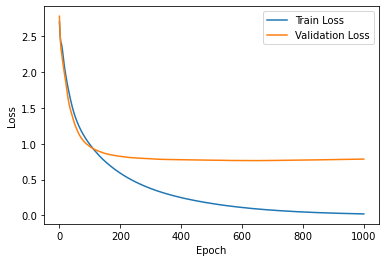

In [7]:
train_loss, val_loss = run()
plt.plot(range(len(train_loss)), train_loss, label=f'Train Loss')
plt.plot(range(len(val_loss)), val_loss, label=f'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3. Zbadaj wpływ tempa uczenia (learning rate) na osiągane wyniki: powtórz uczenie dla 3 różnych wartości parametru. Dobierz odpowiednią długość procesu uczenia (liczbę epok) jeśli to konieczne. Przedstaw wyniki na wykresach jak w zadaniu poprzednim. Co dzieje się, gdy tempo uczenia jest zbyt niskie? Co, gdy zbyt wysokie?

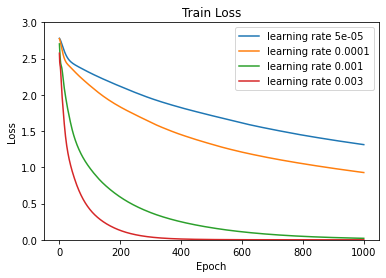

In [8]:
learning_rates = [0.00005, 0.0001, 0.001, 0.003]

for lr in learning_rates:
    train_loss, val_loss =  run(learning_rate_param=lr)
    plt.plot(range(len(train_loss)), train_loss, label=f'learning rate {lr}')
    
plt.title('Train Loss')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

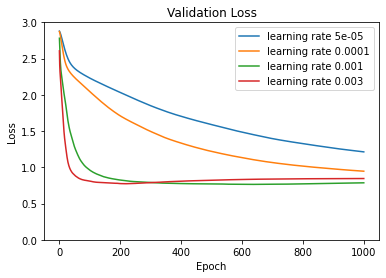

In [9]:
for lr in learning_rates:
    train_loss, val_loss =  run(learning_rate_param=lr)
    plt.plot(range(len(val_loss)), val_loss, label=f'learning rate {lr}')
    
plt.title('Validation Loss')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

W przypadku algorytmu uczenia maszynowego MLPRegressor, tempo uczenia odgrywa ważną rolę w procesie uczenia sieci neuronowej. Tempo uczenia odnosi się do szybkości, z jaką model dostosowuje swoje wagi na podstawie błędu predykcji. Zbyt niskie i zbyt wysokie tempo uczenia może mieć różne konsekwencje

Gdy tempo uczenia jest zbyt niskie:

• Proces uczenia może być powolny i wymagać większej liczby epok, aby model osiągnął zadowalające wyniki.
• Może istnieć ryzyko, że model utknie w lokalnym minimum, niezdolny do znalezienia optymalnego rozwiązania.
• Istnieje możliwość, że model będzie miał trudności z dopasowaniem się do złożonych wzorców w danych, co prowadzi do niższej wydajności predykcyjnej.

Gdy tempo uczenia jest zbyt wysokie:

• Proces uczenia może być bardzo szybki, co oznacza, że model może szybko dostosować się do danych treningowych.
• Może wystąpić ryzyko, że model będzie nadmiernie reagować na szum w danych treningowych, co prowadzi do przeuczenia.
• Model może mieć trudności z uogólnianiem wzorców na nowe dane, co prowadzi do niższej wydajności predykcyjnej na danych testowych.
• W skrajnych przypadkach, gdy tempo uczenia jest ekstremalnie wysokie, wagi mogą się "rozbiec" i model może nie zbiegać się do optymalnego rozwiązania.

# 4. Zbadaj wpływ rozmiaru modelu MLP na jakość działania: wykonaj co najmniej 3 eksperymenty dla modeli różniących się liczbą neuronów. Kiedy model przestaje dobrze dopasowywać się do danych? Kiedy zaczyna zanadto dopasowywać się do zbioru uczącego?

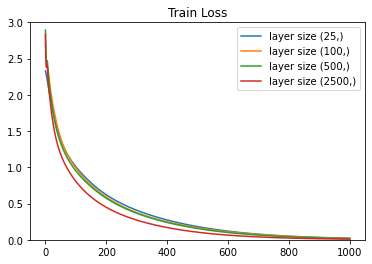

In [10]:
hidden_layer_sizes = [(25,), (100,), (500,), (2500,)]

for size in hidden_layer_sizes:
    train_loss, val_loss = run(learning_rate_param=0.001, hidden_sizes=size)
    plt.plot(range(len(train_loss)), train_loss, label=f'layer size {size}')
plt.title('Train Loss')
plt.ylim(0, 3) 
plt.legend()
plt.show()

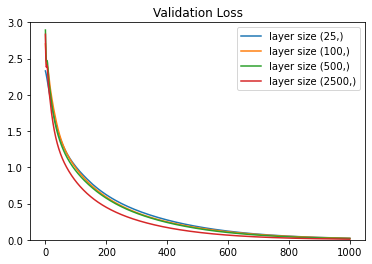

In [11]:
for size in hidden_layer_sizes:
    train_loss, val_loss = run(learning_rate_param=0.001, hidden_sizes=size)
    plt.plot(range(len(val_loss)), train_loss, label=f'layer size {size}')
plt.title('Validation Loss')
plt.ylim(0, 3)
plt.legend()
plt.show()

# 5. Wybierz najlepszy uzyskany w drodze powyższych eksperymentów model i przetestuj go w praktyce: znajdź (lub napisz własny) tekst o charakterze dowcipu, przetwórz go na wektor za pomocą używanej w zadaniach metody ekstrakcji cech, a następnie odpytaj model neuronowy. Czy predykcja zgadza się z Twoim oczekiwaniem?

In [12]:
my_mlp = MLPRegressor(solver='sgd', 
                       alpha=0.0, 
                       learning_rate='constant',
                       learning_rate_init=0.001, 
                       hidden_layer_sizes=(100,),
                       random_state=7
                       )

my_mlp.fit(train_X, train_y)

C:\Users\Piotr\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.0, random_state=7, solver='sgd')

In [13]:
def my_joke(joke):
    joke_embedding = model.encode([joke])
    joke_embedding = np.reshape(joke_embedding, (1, -1))
    rating_prediction = my_mlp.predict(joke_embedding)
    print("Predykcja oceny żartu:", rating_prediction, "\n")
    
jokes = [
    "Why did the scarecrow win an award? Because he was outstanding in his field!",
    "Why don't scientists trust atoms anymore? Because they make up everything!",
    "Why couldn't the bicycle stand up by itself? It was two tired",
    "Why don't skeletons fight each other? They don't have the guts!",
    "What do you call a bear with no teeth? A gummy bear!",
    "Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum."
]

In [14]:
for joke in jokes:
    print(joke)
    my_joke(joke)

Why did the scarecrow win an award? Because he was outstanding in his field!
Predykcja oceny żartu: [-0.8665695] 

Why don't scientists trust atoms anymore? Because they make up everything!
Predykcja oceny żartu: [-1.3128527] 

Why couldn't the bicycle stand up by itself? It was two tired
Predykcja oceny żartu: [-1.7342541] 

Why don't skeletons fight each other? They don't have the guts!
Predykcja oceny żartu: [-1.053306] 

What do you call a bear with no teeth? A gummy bear!
Predykcja oceny żartu: [-1.41627] 

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recen